# Virtual data set (VDS) reference file for OSTIA-UKMO-L4-GLOB-REP-v2.0 using Virtualizarr


In [3]:
# Built-in packages
import os
import sys
import shutil

# Filesystem management 
import fsspec
import earthaccess

# Data handling
import numpy as np
import xarray as xr
from virtualizarr import open_virtual_dataset
import pandas as pd

# Parallel computing 
import multiprocessing
from dask import delayed
import dask.array as da
from dask.distributed import Client
import coiled

# Other
import matplotlib.pyplot as plt

## 1. Get Data File S3 endpoints in Earthdata Cloud

In [4]:
# Get Earthdata creds
earthaccess.login()

Enter your Earthdata Login username:  deanh808
Enter your Earthdata password:  ········


In [5]:
# Get AWS creds. Note that if you spend more than 1 hour in the notebook, you may have to re-run this line!!!
fs = earthaccess.get_s3_filesystem(daac="PODAAC")

In [6]:
# Locate file information / metadata:
shortname = "OSTIA-UKMO-L4-GLOB-REP-v2.0"
granule_info = earthaccess.search_data(
    short_name=shortname,
    )

In [7]:
# Get S3 endpoints for all files:
data_s3links = [g.data_links(access="direct")[0] for g in granule_info]
print("Number of granules found =", len(data_s3links))
print("First few granules:")
data_s3links[0:5]

Number of granules found = 15340
First few granules:


['s3://podaac-ops-cumulus-protected/OSTIA-UKMO-L4-GLOB-REP-v2.0/1982/001/19820101120000-UKMO-L4_GHRSST-SSTfnd-OSTIA-GLOB_REP-v02.0-fv02.0.nc',
 's3://podaac-ops-cumulus-protected/OSTIA-UKMO-L4-GLOB-REP-v2.0/1982/002/19820102120000-UKMO-L4_GHRSST-SSTfnd-OSTIA-GLOB_REP-v02.0-fv02.0.nc',
 's3://podaac-ops-cumulus-protected/OSTIA-UKMO-L4-GLOB-REP-v2.0/1982/003/19820103120000-UKMO-L4_GHRSST-SSTfnd-OSTIA-GLOB_REP-v02.0-fv02.0.nc',
 's3://podaac-ops-cumulus-protected/OSTIA-UKMO-L4-GLOB-REP-v2.0/1982/004/19820104120000-UKMO-L4_GHRSST-SSTfnd-OSTIA-GLOB_REP-v02.0-fv02.0.nc',
 's3://podaac-ops-cumulus-protected/OSTIA-UKMO-L4-GLOB-REP-v2.0/1982/005/19820105120000-UKMO-L4_GHRSST-SSTfnd-OSTIA-GLOB_REP-v02.0-fv02.0.nc']

## 2. Generate single-orbit reference files

One file per orbit, so one reference file per orbit.

In [16]:
open_virtual_dataset(data_s3links[0], indexes={}, reader_options=reader_opts, loadable_variables=coord_vars, decode_times=False,) #decode_cf=False)

<xarray.Dataset> Size: 156MB
Dimensions:           (time: 1, lat: 3600, lon: 7200)
Coordinates:
  * time              (time) datetime64[ns] 8B 1982-01-01T12:00:00
  * lat               (lat) float32 14kB -89.97 -89.93 -89.88 ... 89.93 89.97
  * lon               (lon) float32 29kB -180.0 -179.9 -179.9 ... 179.9 180.0
Data variables:
    analysed_sst      (time, lat, lon) int16 52MB ManifestArray<shape=(1, 360...
    sea_ice_fraction  (time, lat, lon) int8 26MB ManifestArray<shape=(1, 3600...
    mask              (time, lat, lon) int8 26MB ManifestArray<shape=(1, 3600...
    analysis_error    (time, lat, lon) int16 52MB ManifestArray<shape=(1, 360...
Attributes: (12/47)
    Conventions:                CF-1.4, ACDD-1.3
    Metadata_Conventions:       Unidata Observation Dataset v1.0
    acknowledgment:             Please acknowledge the use of these data with...
    cdm_data_type:              grid
    comment:                    WARNING Some applications are unable to prope...
    creator_email:              servicedesk.cmems@mercator-ocean.eu
    ...                         ...
    summary:                    A merged, multi-sensor L4 Foundation SST product
    time_coverage_end:          19820102T000000Z
    time_coverage_start:        19820101T000000Z
    title:                      Global SST & Sea Ice Analysis, L4 OSTIA, 0.05...
    uuid:                       a2df4a18-6f19-4772-9532-39307a0e2794
    westernmost_longitude:      -180.0

In [9]:
# This will be assigned to 'loadable_variables' and needs to be modified per the specific 
# coord names of the data set:
coord_vars = ["time", "lat", "lon"]

In [11]:
print("CPU count =", multiprocessing.cpu_count())

CPU count = 32


In [13]:
reader_opts = {"storage_options": fs.storage_options} # S3 filesystem creds from previous section.

In [13]:
# Start up cluster and print some information about it:
client = Client(n_workers=30, threads_per_worker=1)
print(client.cluster)
print("View any work being done on the cluster here", client.dashboard_link)

LocalCluster(235a1bf2, 'tcp://127.0.0.1:40499', workers=30, threads=30, memory=122.29 GiB)
View any work being done on the cluster here https://cluster-ievfi.dask.host/jupyter/proxy/8787/status


In [17]:
%%time
# Create individual references:
open_vds_par = delayed(open_virtual_dataset)
tasks = [
    open_vds_par(p, indexes={}, reader_options=reader_opts, loadable_variables=coord_vars) 
    for p in data_s3links[:]
    ]
virtual_ds_list = list(da.compute(*tasks)) # The xr.combine_nested() function below needs a list rather than a tuple.

CPU times: user 38.6 s, sys: 5.93 s, total: 44.6 s
Wall time: 1min 29s


In [18]:
len(virtual_ds_list)

8369

## 3. Generate combined reference file

In [19]:
%%time
# Create the combined reference
virtual_ds_combined = xr.combine_nested(virtual_ds_list, concat_dim='time', coords='minimal', compat='override', combine_attrs='drop_conflicts')

CPU times: user 5.51 s, sys: 218 ms, total: 5.73 s
Wall time: 5.48 s


In [20]:
# Save in JSON or PARQUET format:
fname_combined_json = shortname + "_virtual_s3" + ".json"
virtual_ds_combined.virtualize.to_kerchunk(fname_combined_json, format='json')

## 4. Test combined reference files

In [21]:
def opends_withref(ref, fs_data):
    """
    "ref" is a reference file or object. "fs_data" is a filesystem with credentials to
    access the actual data files. 
    """
    storage_opts = {"fo": ref, "remote_protocol": "s3", "remote_options": fs_data.storage_options}
    fs_ref = fsspec.filesystem('reference', **storage_opts)
    m = fs_ref.get_mapper('')
    data = xr.open_dataset(
        m, engine="zarr", chunks={},
        backend_kwargs={"consolidated": False}
    )
    return data

### 4.1 JSON reference file

In [22]:
%%time
data = opends_withref(fname_combined_json, fs)
data

CPU times: user 187 ms, sys: 22 ms, total: 209 ms
Wall time: 197 ms


<xarray.Dataset> Size: 312GB
Dimensions:           (time: 8369, lat: 720, lon: 1440)
Coordinates:
  * lat               (lat) float32 3kB -89.88 -89.62 -89.38 ... 89.62 89.88
  * lon               (lon) float32 6kB -179.9 -179.6 -179.4 ... 179.6 179.9
  * time              (time) datetime64[ns] 67kB 2002-09-01T09:00:00 ... 2025...
Data variables:
    analysed_sst      (time, lat, lon) float64 69GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    analysis_error    (time, lat, lon) float64 69GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    mask              (time, lat, lon) float32 35GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float64 69GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    sst_anomaly       (time, lat, lon) float64 69GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes: (12/40)
    Conventions:                CF-1.7, ACDD-1.3
    acknowledgment:             Please acknowledge the use of these data with...
    cdm_data_type:              grid
    creator_email:              ghrsst@podaac.jpl.nasa.gov
    creator_institution:        Jet Propulsion Laboratory
    creator_name:               JPL MUR SST project
    ...                         ...
    spatial_resolution:         0.25 degrees
    standard_name_vocabulary:   NetCDF Climate and Forecast (CF) Metadata Con...
    summary:                    A low-resolution version of the MUR SST analy...
    time_coverage_resolution:   P1D
    uuid:                       27665bc0-d5fc-11e1-9b23-0800200c9a66
    westernmost_longitude:      -180.0

In [26]:
lat_range = (0, 45)
lon_range = (-130, -100)
time_range = (np.datetime64("2010-01-01"), np.datetime64("2010-01-02"))
data_subset = data.sel(lat=slice(*lat_range), lon=slice(*lon_range), time=slice(*time_range))
data_subset

<xarray.Dataset> Size: 779kB
Dimensions:           (time: 1, lat: 180, lon: 120)
Coordinates:
  * lat               (lat) float32 720B 0.125 0.375 0.625 ... 44.38 44.62 44.88
  * lon               (lon) float32 480B -129.9 -129.6 -129.4 ... -100.4 -100.1
  * time              (time) datetime64[ns] 8B 2010-01-01T09:00:00
Data variables:
    analysed_sst      (time, lat, lon) float64 173kB dask.array<chunksize=(1, 180, 120), meta=np.ndarray>
    analysis_error    (time, lat, lon) float64 173kB dask.array<chunksize=(1, 180, 120), meta=np.ndarray>
    mask              (time, lat, lon) float32 86kB dask.array<chunksize=(1, 180, 120), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float64 173kB dask.array<chunksize=(1, 180, 120), meta=np.ndarray>
    sst_anomaly       (time, lat, lon) float64 173kB dask.array<chunksize=(1, 180, 120), meta=np.ndarray>
Attributes: (12/40)
    Conventions:                CF-1.7, ACDD-1.3
    acknowledgment:             Please acknowledge the use of these data with...
    cdm_data_type:              grid
    creator_email:              ghrsst@podaac.jpl.nasa.gov
    creator_institution:        Jet Propulsion Laboratory
    creator_name:               JPL MUR SST project
    ...                         ...
    spatial_resolution:         0.25 degrees
    standard_name_vocabulary:   NetCDF Climate and Forecast (CF) Metadata Con...
    summary:                    A low-resolution version of the MUR SST analy...
    time_coverage_resolution:   P1D
    uuid:                       27665bc0-d5fc-11e1-9b23-0800200c9a66
    westernmost_longitude:      -180.0

In [28]:
ws_mean_map = data_subset["analysed_sst"].mean(dim="time").compute()

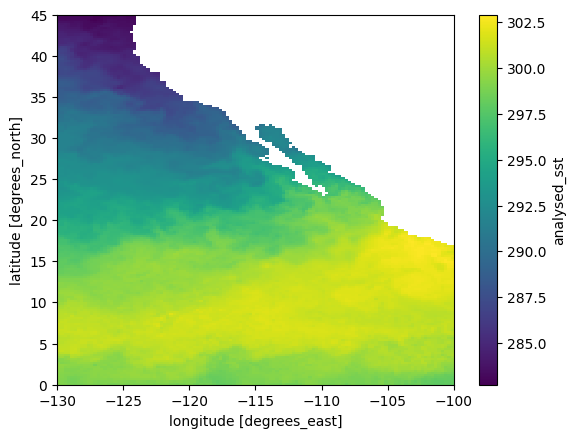

In [29]:
ws_mean_map.plot()